In [1]:
import xarray as xr
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
import pandas as pd
import tqdm

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]

def get_point_data(time,lat,lon,r,var,plot=False,vmin=None,vmax=None):
    
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})
    
    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    mask = get_mask(lons,lats)
    a,b = np.where( (dist_km <= r) & (mask == 1) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(lon=target_lons, lat=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r) & (mask == 1), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    #Return the value of the point with the highest absolute value
    return pd.DataFrame([f_slice[v].values[np.abs(f_slice[v]).argmax()] for v in var], index=var)


In [2]:
details_list = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"2", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"2", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"2", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"2", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"2", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"2", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"2", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"2", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"2", "title":"i) Melbourne:  UTC"},\
       \
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"71", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"71", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"71", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"71", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"71", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"71", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"71", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"71", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"71", "title":"i) Sydney: UTC"},\
       \
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"66", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"66", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"50", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"50", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"66", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"50", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"50", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"66", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"50", "title":"i) Oakey: UTC"},\
       \
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"27", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"27", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"27", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"27", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"27", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"27", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"27", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"27", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"27", "title":"i) "},\
         ]

In [260]:
df = pd.DataFrame()
for details in tqdm.tqdm(details_list):
    df = pd.concat([df, 
        get_point_data(details["time"][0], details["lat"], details["lon"], 50, ["mu_cape","dcape","s06","Umean06"], plot=False).T],
                   axis=0)
        

100%|██████████| 36/36 [00:14<00:00,  2.51it/s]


In [261]:
from minisom import MiniSom

df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

som_shape = (3,1)
som = MiniSom(som_shape[0], som_shape[1], df.shape[1], sigma=0.5, learning_rate=0.5, neighborhood_function="gaussian", random_seed=1000)
som.train(df_norm.values, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.3395587561958218


In [262]:
winner_coords = np.array([som.winner(x) for x in df_norm.values]).T
cluster_index = np.ravel_multi_index(winner_coords, som_shape)

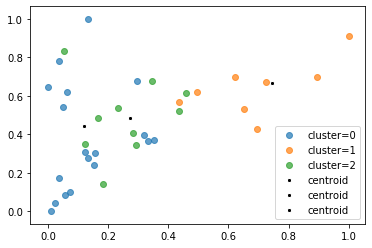

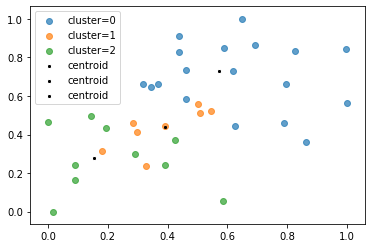

In [263]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(df_norm.values[cluster_index == c, 0],
                df_norm.values[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=5, linewidths=10, color='k', label='centroid')
plt.legend();

plt.figure()
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(df_norm.values[cluster_index == c, 3],
                df_norm.values[cluster_index == c, 2], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 3], centroid[:, 2], marker='x', 
                s=5, linewidths=10, color='k', label='centroid')
plt.legend();

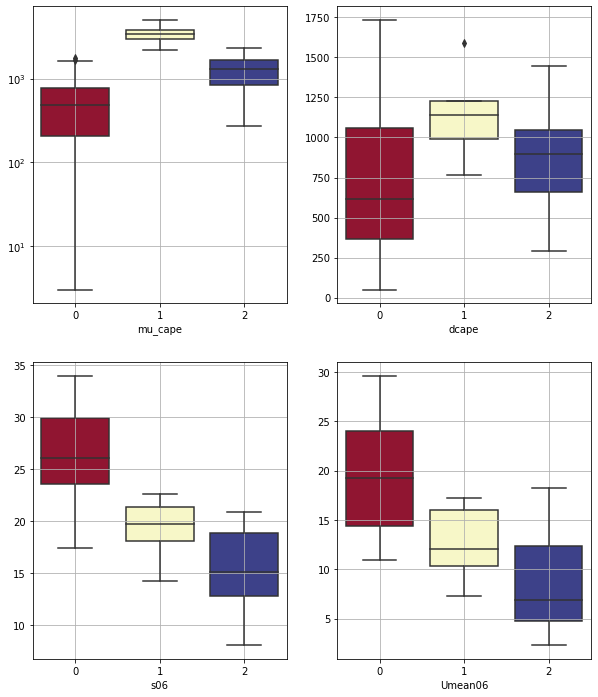

In [264]:
import seaborn as sns

p = [plt.get_cmap("RdYlBu")(i) for i in np.linspace(0,1,len(np.unique(cluster_index)))]

plt.figure(figsize=[10,12])

specify_order=False
order=[1,3,2,0]

cnt=1
for v in df.columns:
    plt.subplot(np.ceil((df.shape[1]) / 2),2,cnt)
    if specify_order:
        sns.boxplot(data=[df.loc[cluster_index==c][v] for c in order], palette=p)
        plt.xticks(np.arange(len(np.unique(cluster_index))), order)
    else:
        sns.boxplot(data=[df.loc[cluster_index==c][v] for c in np.unique(cluster_index)], palette=p)
    if v in ["mu_cape"]:
        plt.yscale("symlog")
    plt.gca().grid()
    plt.xlabel(v)
    cnt=cnt+1


In [242]:
pd.DataFrame({"time":[d["time"][0] for d in details_list], "rid":[d["rid"] for d in details_list], "cluster":cluster_index})

,time,rid,cluster
0,2006-09-24 01:41:00,2,1
1,2009-11-20 03:06:00,2,3
2,2010-03-06 03:30:00,2,3
3,2010-06-17 00:25:00,2,1
4,2011-11-18 07:04:00,2,3
5,2011-12-25 06:45:00,2,3
6,2012-02-26 09:11:00,2,2
7,2013-03-21 03:45:00,2,1
8,2015-02-28 09:25:00,2,3
9,2010-08-02 15:43:00,71,1
